In [1]:
# setup e test librerie
%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install scikit-learn
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [5]:
dailyActivity_merged = pd.read_csv("Fitabase Data 4.12.16-5.12.16/dailyActivity_merged.csv")
dailyCalories_merged = pd.read_csv("Fitabase Data 4.12.16-5.12.16/dailyCalories_merged.csv")
dailyIntensities_merged = pd.read_csv("Fitabase Data 4.12.16-5.12.16/dailyIntensities_merged.csv")
dailySteps_merged = pd.read_csv("Fitabase Data 4.12.16-5.12.16/dailySteps_merged.csv")
sleepDay_merged = pd.read_csv("Fitabase Data 4.12.16-5.12.16/sleepDay_merged.csv")
weightLogInfo_merged = pd.read_csv("Fitabase Data 4.12.16-5.12.16/weightLogInfo_merged.csv")

In [6]:
merge_1 = pd.merge(dailyActivity_merged, dailyCalories_merged, on=["Id", "Calories"])
merge_2 = pd.merge(dailyIntensities_merged, dailyIntensities_merged, on=["Id","ActivityDay","SedentaryMinutes", "LightlyActiveMinutes","FairlyActiveMinutes","VeryActiveMinutes", "SedentaryActiveDistance", "LightActiveDistance", "ModeratelyActiveDistance", "VeryActiveDistance"])
merge_daily = pd.merge(merge_1, merge_2, on = ["Id","ActivityDay","SedentaryMinutes", "LightlyActiveMinutes","FairlyActiveMinutes","VeryActiveMinutes", "SedentaryActiveDistance", "LightActiveDistance", "ModeratelyActiveDistance", "VeryActiveDistance"])
daily_data = pd.merge(merge_daily, sleepDay_merged, on = "Id")
daily_data.describe()

,Id,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed
count,1.590100e+04,15901.000000,15901.000000,15901.000000,15901.000000,15901.000000,15901.000000,15901.000000,15901.000000,15901.000000,15901.000000,15901.000000,15901.000000,15901.000000,15901.000000,15901.000000,15901.000000
mean,5.116919e+09,6351.012138,4.486880,4.481426,0.096494,1.094280,0.572868,2.771094,0.000528,18.756996,13.576442,156.408025,938.631658,2220.168291,1.115716,417.299164,456.068109
std,2.184244e+09,5187.657882,3.718941,3.711934,0.491847,1.787582,0.966130,2.212866,0.006917,32.425740,21.584289,119.173005,354.396671,711.184059,0.355114,123.067587,139.639428
min,1.503960e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,58.000000,61.000000
25%,4.020333e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,687.000000,1693.000000,1.000000,360.000000,402.000000
50%,4.702922e+09,6393.000000,4.480000,4.480000,0.000000,0.000000,0.110000,2.860000,0.000000,0.000000,3.000000,171.000000,781.000000,2013.000000,1.000000,427.000000,459.000000
75%,6.962181e+09,10460.000000,7.390000,7.390000,0.000000,1.740000,0.790000,4.480000,0.000000,28.000000,19.000000,240.000000,1440.000000,2643.000000,1.000000,490.000000,530.000000
max,8.792010e+09,22988.000000,17.950001,17.950001,4.942142,13.400000,6.480000,10.300000,0.110000,210.000000,143.000000,518.000000,1440.000000,4900.000000,3.000000,796.000000,961.000000


In [10]:
daily_data["SleepClassification"] = "Buono"  # Imposta il valore predefinito a "Buono"
# Applica la regola per classificare il sonno come "cattivo" se TotalMinutesAsleep è inferiore al 50% di TotalTimeInBed
daily_data.loc[daily_data["TotalMinutesAsleep"] <  0.8* daily_data["TotalTimeInBed"], "SleepClassification"] = "Cattivo"

In [11]:
from sklearn.model_selection import train_test_split
# Seleziona le colonne di input e l'etichetta di classe
#X = daily_data[["TotalSleepRecords", "TotalMinutesAsleep", "TotalTimeInBed"]]
X = daily_data[["TotalMinutesAsleep", "TotalTimeInBed"]]
y = daily_data['SleepClassification']
# Dividi il dataset in training set e test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42)


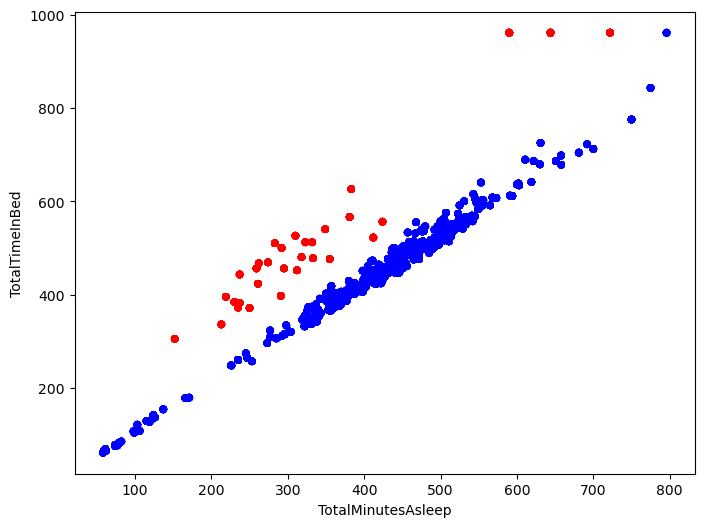

In [12]:
diagnosis_color_map = {"Buono": "blue", "Cattivo": "red"}
X_train.plot.scatter("TotalMinutesAsleep", "TotalTimeInBed", c=y_train.map(diagnosis_color_map), figsize=(8, 6));

In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X2dn_train = scaler.fit_transform(X_train)
X2dn_val = scaler.transform(X_test)

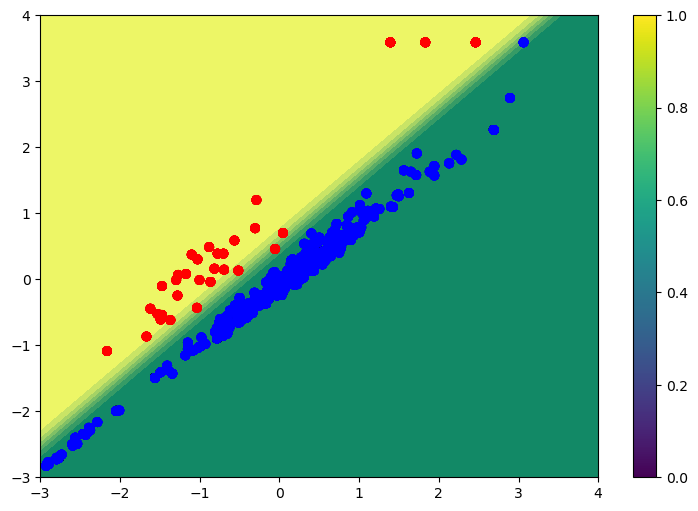

In [14]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver="saga", random_state=42)
model.fit(X2dn_train, y_train)
mx1, mx2 = np.meshgrid(np.linspace(-3, 4, 100), np.linspace(-3, 4, 100))
my = model.predict_proba(np.c_[mx1.ravel(), mx2.ravel()])[:, 1].reshape(mx1.shape)
plt.figure(figsize=(9, 6))
plt.contourf(mx1, mx2, my, cmap="summer")
plt.scatter(*X2dn_train.T, c=y_train.map(diagnosis_color_map))
plt.colorbar();

In [15]:
model.score(X2dn_val, y_test)

0.9986794944350122